# Introduction

Here, we will demonstrate the use of generalized additive models and trees. For this work, we will be reusing our Lab 2
dataset.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

from pymatgen import Composition

rcparams = {'legend.fontsize': 20,
            'figure.figsize': (12, 8),
            'axes.labelsize': 24,
            'axes.titlesize': 28,
            'xtick.labelsize':20,
            'ytick.labelsize': 20}
sns.set(rc=rcparams)
mpl.rcParams.update(rcparams)

%matplotlib inline
%config InlineBackend.figure_format ='retina'

In [2]:
# by default pandas will recognize NaN (sodium nitride) as nan (not a number)
# to turn off this behavior, we use na_filter=False
data = pd.read_csv("../labs/lab2/data.csv", index_col=0, na_filter=False)


# Let's create a column of Composition objects using pymatgen.
data["composition"] = [Composition(f) for f in data["formula"]]
print(data.head())

           formula  formation_energy_per_atom  e_above_hull  band_gap  \
task_id                                                                 
mp-1007923   CrNi3                  -0.016354      0.000802       0.0   
mp-1008754   TbHg2                  -0.069428      0.329909       0.0   
mp-1016886   MgVO3                  -2.241438      0.545977       0.0   
mp-1018902  PrSbPt                  -1.111238      0.000000       0.0   
mp-1020595  Rb8PO3                  -0.772860      0.491666       0.0   

            has_bandstructure   composition  
task_id                                      
mp-1007923              False      (Cr, Ni)  
mp-1008754               True      (Tb, Hg)  
mp-1016886               True    (Mg, V, O)  
mp-1018902               True  (Pr, Sb, Pt)  
mp-1020595               True    (Rb, P, O)  


Here, we load the elemental data. Unlike lab2, we are simply going to disregard all elemental features that contain NaN. While imputing the mean value is a commonly used data science technique, it really does not work well for materials science problems. 

In [3]:
el_data = pd.read_csv("../labs/lab2/element_properties.csv", index_col=0)
el_data = el_data[['AtomicRadius', 'AtomicWeight', 'Column', 'ElectronAffinity', 
                   'Electronegativity', 'FirstIonizationEnergy', 'Row', 'SecondIonizationEnergy']]

As before, we will compute the mean, min, and max for every elemental feature. For mean, we are weighting it by composition.

In [4]:
import collections

props = collections.defaultdict(list)

for comp in data["composition"]:
    for c in el_data.columns:
        vals = [el_data[c][el.symbol] * amt for el, amt in comp.items()]
        props["%sMean" % c].append(sum(vals)/ comp.num_atoms)
        props["%sMin" % c].append(min(vals))
        props["%sMax" % c].append(max(vals))

In [5]:
data = data.assign(**props)
print(data.shape)

(124515, 30)


We drop all data points that contains elements with NaN values again. We are left with around 106k data points, Still more than enough for our purposes.

In [6]:
data = data.dropna()
print(data.shape)
print(data.head())

(106023, 30)
           formula  formation_energy_per_atom  e_above_hull  band_gap  \
task_id                                                                 
mp-1007923   CrNi3                  -0.016354      0.000802       0.0   
mp-1008754   TbHg2                  -0.069428      0.329909       0.0   
mp-1016886   MgVO3                  -2.241438      0.545977       0.0   
mp-1018902  PrSbPt                  -1.111238      0.000000       0.0   
mp-1020595  Rb8PO3                  -0.772860      0.491666       0.0   

            has_bandstructure   composition  AtomicRadiusMean  \
task_id                                                         
mp-1007923              False      (Cr, Ni)          1.362500   
mp-1008754               True      (Tb, Hg)          1.583333   
mp-1016886               True    (Mg, V, O)          0.930000   
mp-1018902               True  (Pr, Sb, Pt)          1.550000   
mp-1020595               True    (Rb, P, O)          1.800000   

            AtomicR

Let's create our features and targets.

In [7]:
features = [c for c in data.columns if c.endswith("Mean") or c.endswith("Min") or c.endswith("Max")]
x = data[features]
y_class = [0 if bg < 1e-4 else 1 for bg in data["band_gap"]]
y_reg = data["band_gap"]
print(x.head())

            AtomicRadiusMean  AtomicRadiusMin  AtomicRadiusMax  \
task_id                                                          
mp-1007923          1.362500             1.40             4.05   
mp-1008754          1.583333             1.75             3.00   
mp-1016886          0.930000             1.35             1.80   
mp-1018902          1.550000             1.35             1.85   
mp-1020595          1.800000             1.00            18.80   

            AtomicWeightMean  AtomicWeightMin  AtomicWeightMax  ColumnMean  \
task_id                                                                      
mp-1007923         57.019075        51.996100         176.0802    9.000000   
mp-1008754        186.701783       158.925350         401.1800    9.000000   
mp-1016886         24.648940        24.305000          50.9415   11.000000   
mp-1018902        152.583883       121.760000         195.0840    9.333333   
mp-1020595         63.559530        30.973762         683.7424    5.9

# Generalized Additive Models

Since sklearn does not have generalized additive models, we will use statsmodels for fitting such models. 

In [8]:
from statsmodels.gam.generalized_additive_model import GLMGam
from statsmodels.gam.api import BSplines
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# GAM model is difficult to train, here we use a very small train data size 
x_train, x_test, y_train, y_test = train_test_split(x, y_class, test_size=0.95)  

In [9]:
# smoother over the 24 variables, with each variable using 6 basis function and degree of 4
# splines
bs = BSplines(x_train, df=[6] * 24, degree=[4] * 24 )

In [10]:
combined_xy = x_train.copy()
combined_xy = combined_xy.assign(**{'is_metal': y_train})

In [11]:
# Gaussian family with Logit link function
binomial = sm.families.Binomial(sm.families.links.logit)
gam_bs = GLMGam.from_formula('is_metal ~ 1', data=combined_xy, 
                             smoother=bs, family=binomial)


/Users/shyue/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.
  


The formula means that other than the generalized additive models using B-Splines, there is only an extra intercept term (1 in "is_metal ~ 1"). 

We can of course include other linear relationship here. For example, if we believe there is an extra linear dependence on `AtomicRadiusMean`, we should write the formula as `is_metal ~ AtomicRadiusMean + 1`. Note that the generalized additive models are added to the relationship.

In [12]:
from time import time

print("Training size %d" % len(x_train))
t0 = time()
res_bs = gam_bs.fit()  # fit the model
print("Training on the data took %.3f seconds" % (time() - t0))

Training size 5301


/Users/shyue/miniconda3/envs/py37/lib/python3.7/site-packages/statsmodels/genmod/families/family.py:894: RuntimeWarning: invalid value encountered in true_divide
  n_endog_mu = self._clean((1. - endog) / (1. - mu))
/Users/shyue/miniconda3/envs/py37/lib/python3.7/site-packages/statsmodels/genmod/families/links.py:188: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/Users/shyue/miniconda3/envs/py37/lib/python3.7/site-packages/statsmodels/genmod/families/family.py:893: RuntimeWarning: invalid value encountered in true_divide
  endog_mu = self._clean(endog / mu)
/Users/shyue/miniconda3/envs/py37/lib/python3.7/site-packages/statsmodels/genmod/families/family.py:894: RuntimeWarning: divide by zero encountered in true_divide
  n_endog_mu = self._clean((1. - endog) / (1. - mu))
/Users/shyue/miniconda3/envs/py37/lib/python3.7/site-packages/statsmodels/genmod/families/family.py:893: RuntimeWarning: divide by zero encountered in true_divide
  endog_mu = self._clean(endog / mu)


Training on the data took 27.661 seconds


/Users/shyue/miniconda3/envs/py37/lib/python3.7/site-packages/statsmodels/genmod/families/links.py:247: RuntimeWarning: divide by zero encountered in true_divide
  return (2*p - 1) / v**2
/Users/shyue/miniconda3/envs/py37/lib/python3.7/site-packages/statsmodels/genmod/generalized_linear_model.py:539: RuntimeWarning: invalid value encountered in multiply
  tmp = score_factor * tmp
/Users/shyue/miniconda3/envs/py37/lib/python3.7/site-packages/statsmodels/gam/generalized_additive_model.py:422: RuntimeWarning: invalid value encountered in sqrt
  wexog = np.sqrt(weights)[:, None] * self.model.exog


In [13]:
n_start = 0
n_end = 1000

transformed = bs.transform(x_test[n_start:n_end].values)
transformed = np.concatenate([np.ones((x_test[n_start:n_end].shape[0], 1)), 
                              transformed], axis=1)  # add intercept

NotImplementedError: some data points fall outside the outermost knots, and I'm not sure how to handle them. (Patches accepted!)

In [ ]:
y_pred_test = gam_bs.predict(res_bs.params, transformed)

In [ ]:
accuracy_score(y_pred_test>=0.5, y_test[n_start:n_end])

# Decision tree classifier

Here, we will construct a decision tree classifier. Let us explore how the classficication accuracy changes with the tree depth.

In [15]:
from sklearn.tree import DecisionTreeClassifier

x_train, x_test, y_train, y_test = train_test_split(x, y_class, test_size=0.2)  

results = []

for d in range(1, 20):
    decision_tree = DecisionTreeClassifier(criterion="entropy", random_state=0, max_depth=d)
    decision_tree = decision_tree.fit(x_train, y_train)
    train_accuracy = decision_tree.score(x_train, y_train)
    test_accuracy = decision_tree.score(x_test, y_test)
    y_pred = decision_tree.predict(x_test)
    results.append((d, 1 - train_accuracy, 1 - test_accuracy))

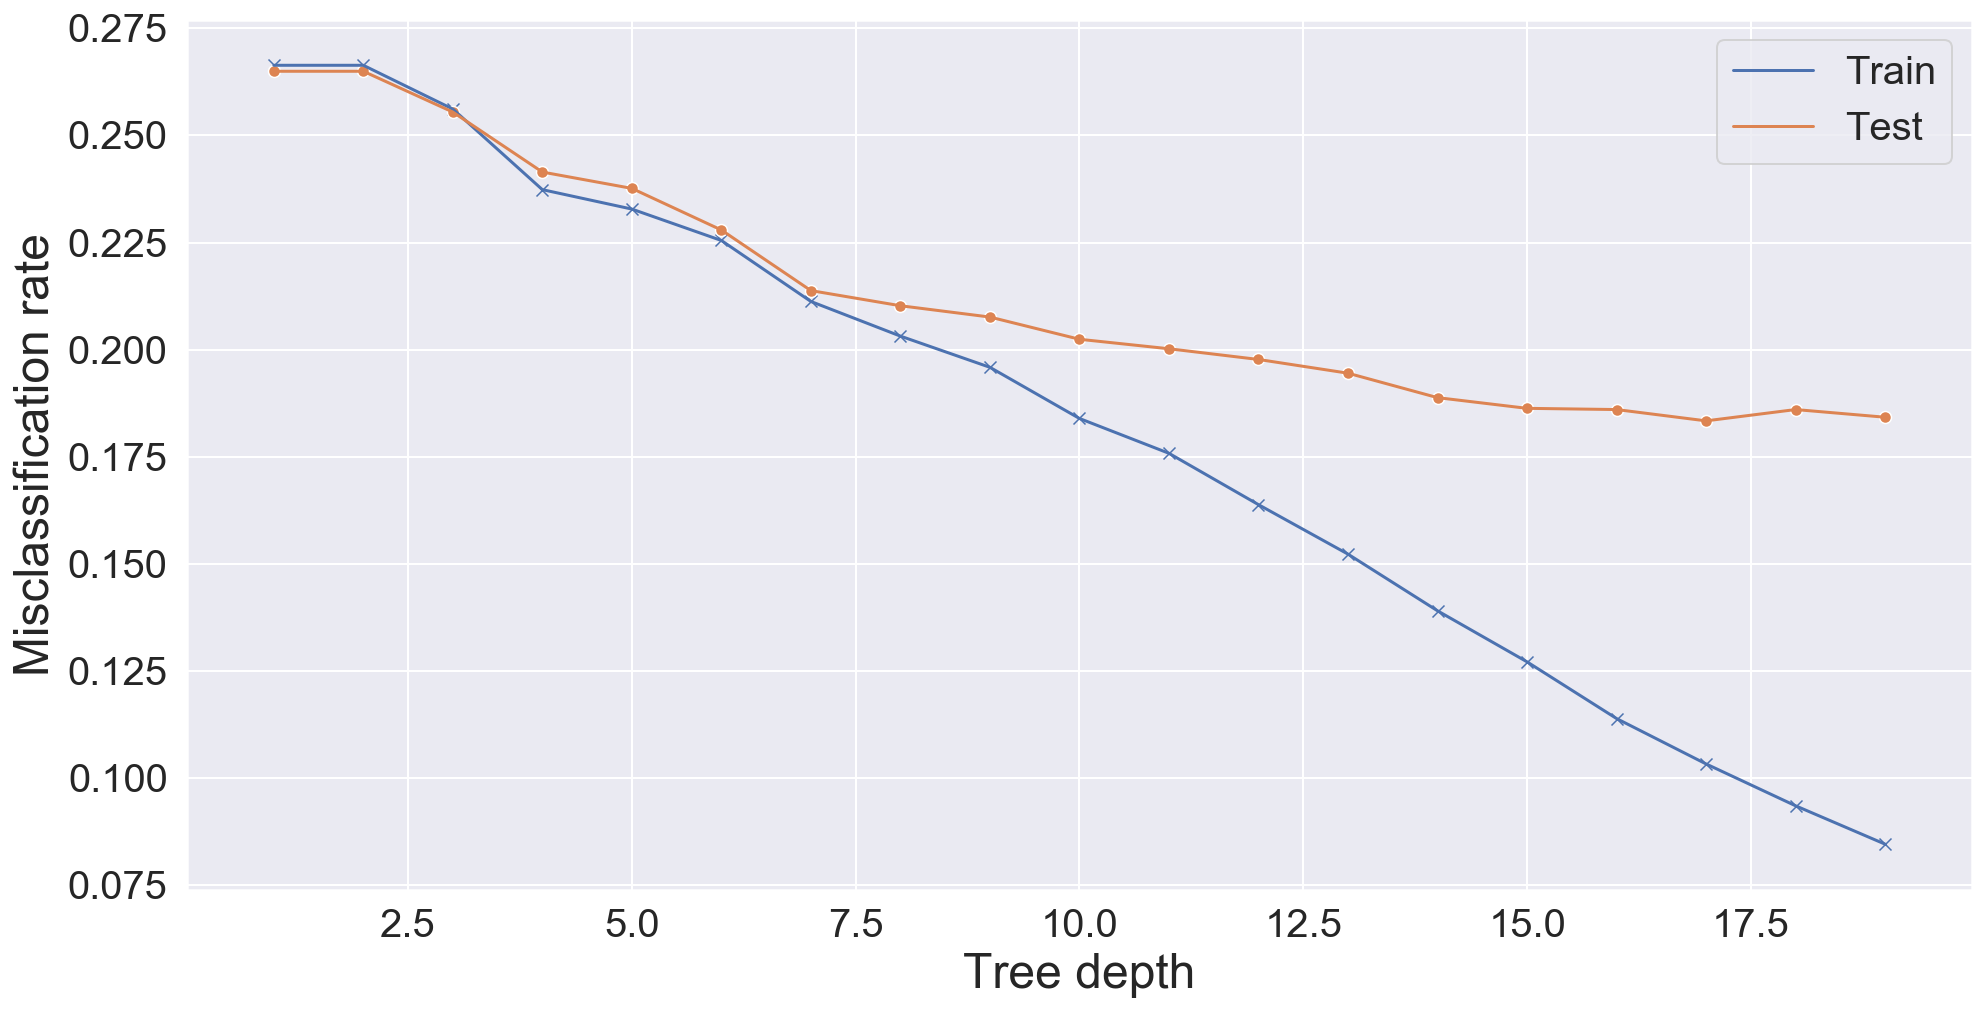

In [16]:
results = pd.DataFrame(results, columns=["Depth", "Train", "Test"])
fig, ax = plt.subplots(figsize=(16, 8))
ax = sns.lineplot(x="Depth", y="Train", data=results)
ax = sns.scatterplot(x="Depth", y="Train", data=results, marker='x')
ax = sns.lineplot(x="Depth", y="Test", data=results)
ax = sns.scatterplot(x="Depth", y="Test", data=results, marker='o')
plt.xlabel("Tree depth")
plt.ylabel("Misclassification rate")
ax.legend(["Train", "Test"]);

We see the test and training misclassification rate diverges after a tree depth of 8, and the test misclassification rate plateaus after a tree depth of 15 or so.

In [17]:
from sklearn.tree import export_text
decision_tree = DecisionTreeClassifier(criterion="entropy", random_state=0, max_depth=5, ccp_alpha=0.01)
decision_tree = decision_tree.fit(x_train, y_train)
train_accuracy = decision_tree.score(x_train, y_train)
test_accuracy = decision_tree.score(x_test, y_test)
r = export_text(decision_tree, feature_names=list(x.columns))
print("Train accuracy = %.3f; test accuracy: %.3f" % (train_accuracy, test_accuracy))
print(r)

Train accuracy = 0.734; test accuracy: 0.735
|--- ElectronegativityMean <= 1.98
|   |--- SecondIonizationEnergyMean <= 19.37
|   |   |--- class: 0
|   |--- SecondIonizationEnergyMean >  19.37
|   |   |--- class: 0
|--- ElectronegativityMean >  1.98
|   |--- SecondIonizationEnergyMean <= 26.96
|   |   |--- class: 1
|   |--- SecondIonizationEnergyMean >  26.96
|   |   |--- class: 1



In [18]:
from sklearn.tree import export_graphviz
export_graphviz(decision_tree, out_file="metal_insulator_tree.dot", feature_names=list(x.columns))

Let's see what happens when we decrease the pruning parameter.

In [19]:
decision_tree = DecisionTreeClassifier(criterion="entropy", random_state=0, max_depth=5, ccp_alpha=0.001)
decision_tree = decision_tree.fit(x_train, y_train)
train_accuracy = decision_tree.score(x_train, y_train)
test_accuracy = decision_tree.score(x_test, y_test)
r = export_text(decision_tree, feature_names=list(x.columns))
print("Train accuracy = %.3f; test accuracy: %.3f" % (train_accuracy, test_accuracy))
print(r)

Train accuracy = 0.767; test accuracy: 0.762
|--- ElectronegativityMean <= 1.98
|   |--- SecondIonizationEnergyMean <= 19.37
|   |   |--- ElectronAffinityMean <= 110.44
|   |   |   |--- FirstIonizationEnergyMean <= 7.56
|   |   |   |   |--- class: 0
|   |   |   |--- FirstIonizationEnergyMean >  7.56
|   |   |   |   |--- AtomicRadiusMax <= 67.08
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- AtomicRadiusMax >  67.08
|   |   |   |   |   |--- class: 1
|   |   |--- ElectronAffinityMean >  110.44
|   |   |   |--- ColumnMean <= 10.24
|   |   |   |   |--- class: 0
|   |   |   |--- ColumnMean >  10.24
|   |   |   |   |--- ElectronAffinityMin <= 47.45
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- ElectronAffinityMin >  47.45
|   |   |   |   |   |--- class: 0
|   |--- SecondIonizationEnergyMean >  19.37
|   |   |--- ElectronAffinityMean <= 94.28
|   |   |   |--- ColumnMax <= 13.50
|   |   |   |   |--- class: 0
|   |   |   |--- ColumnMax >  13.50
|   |   |   |   |--- ColumnMean <

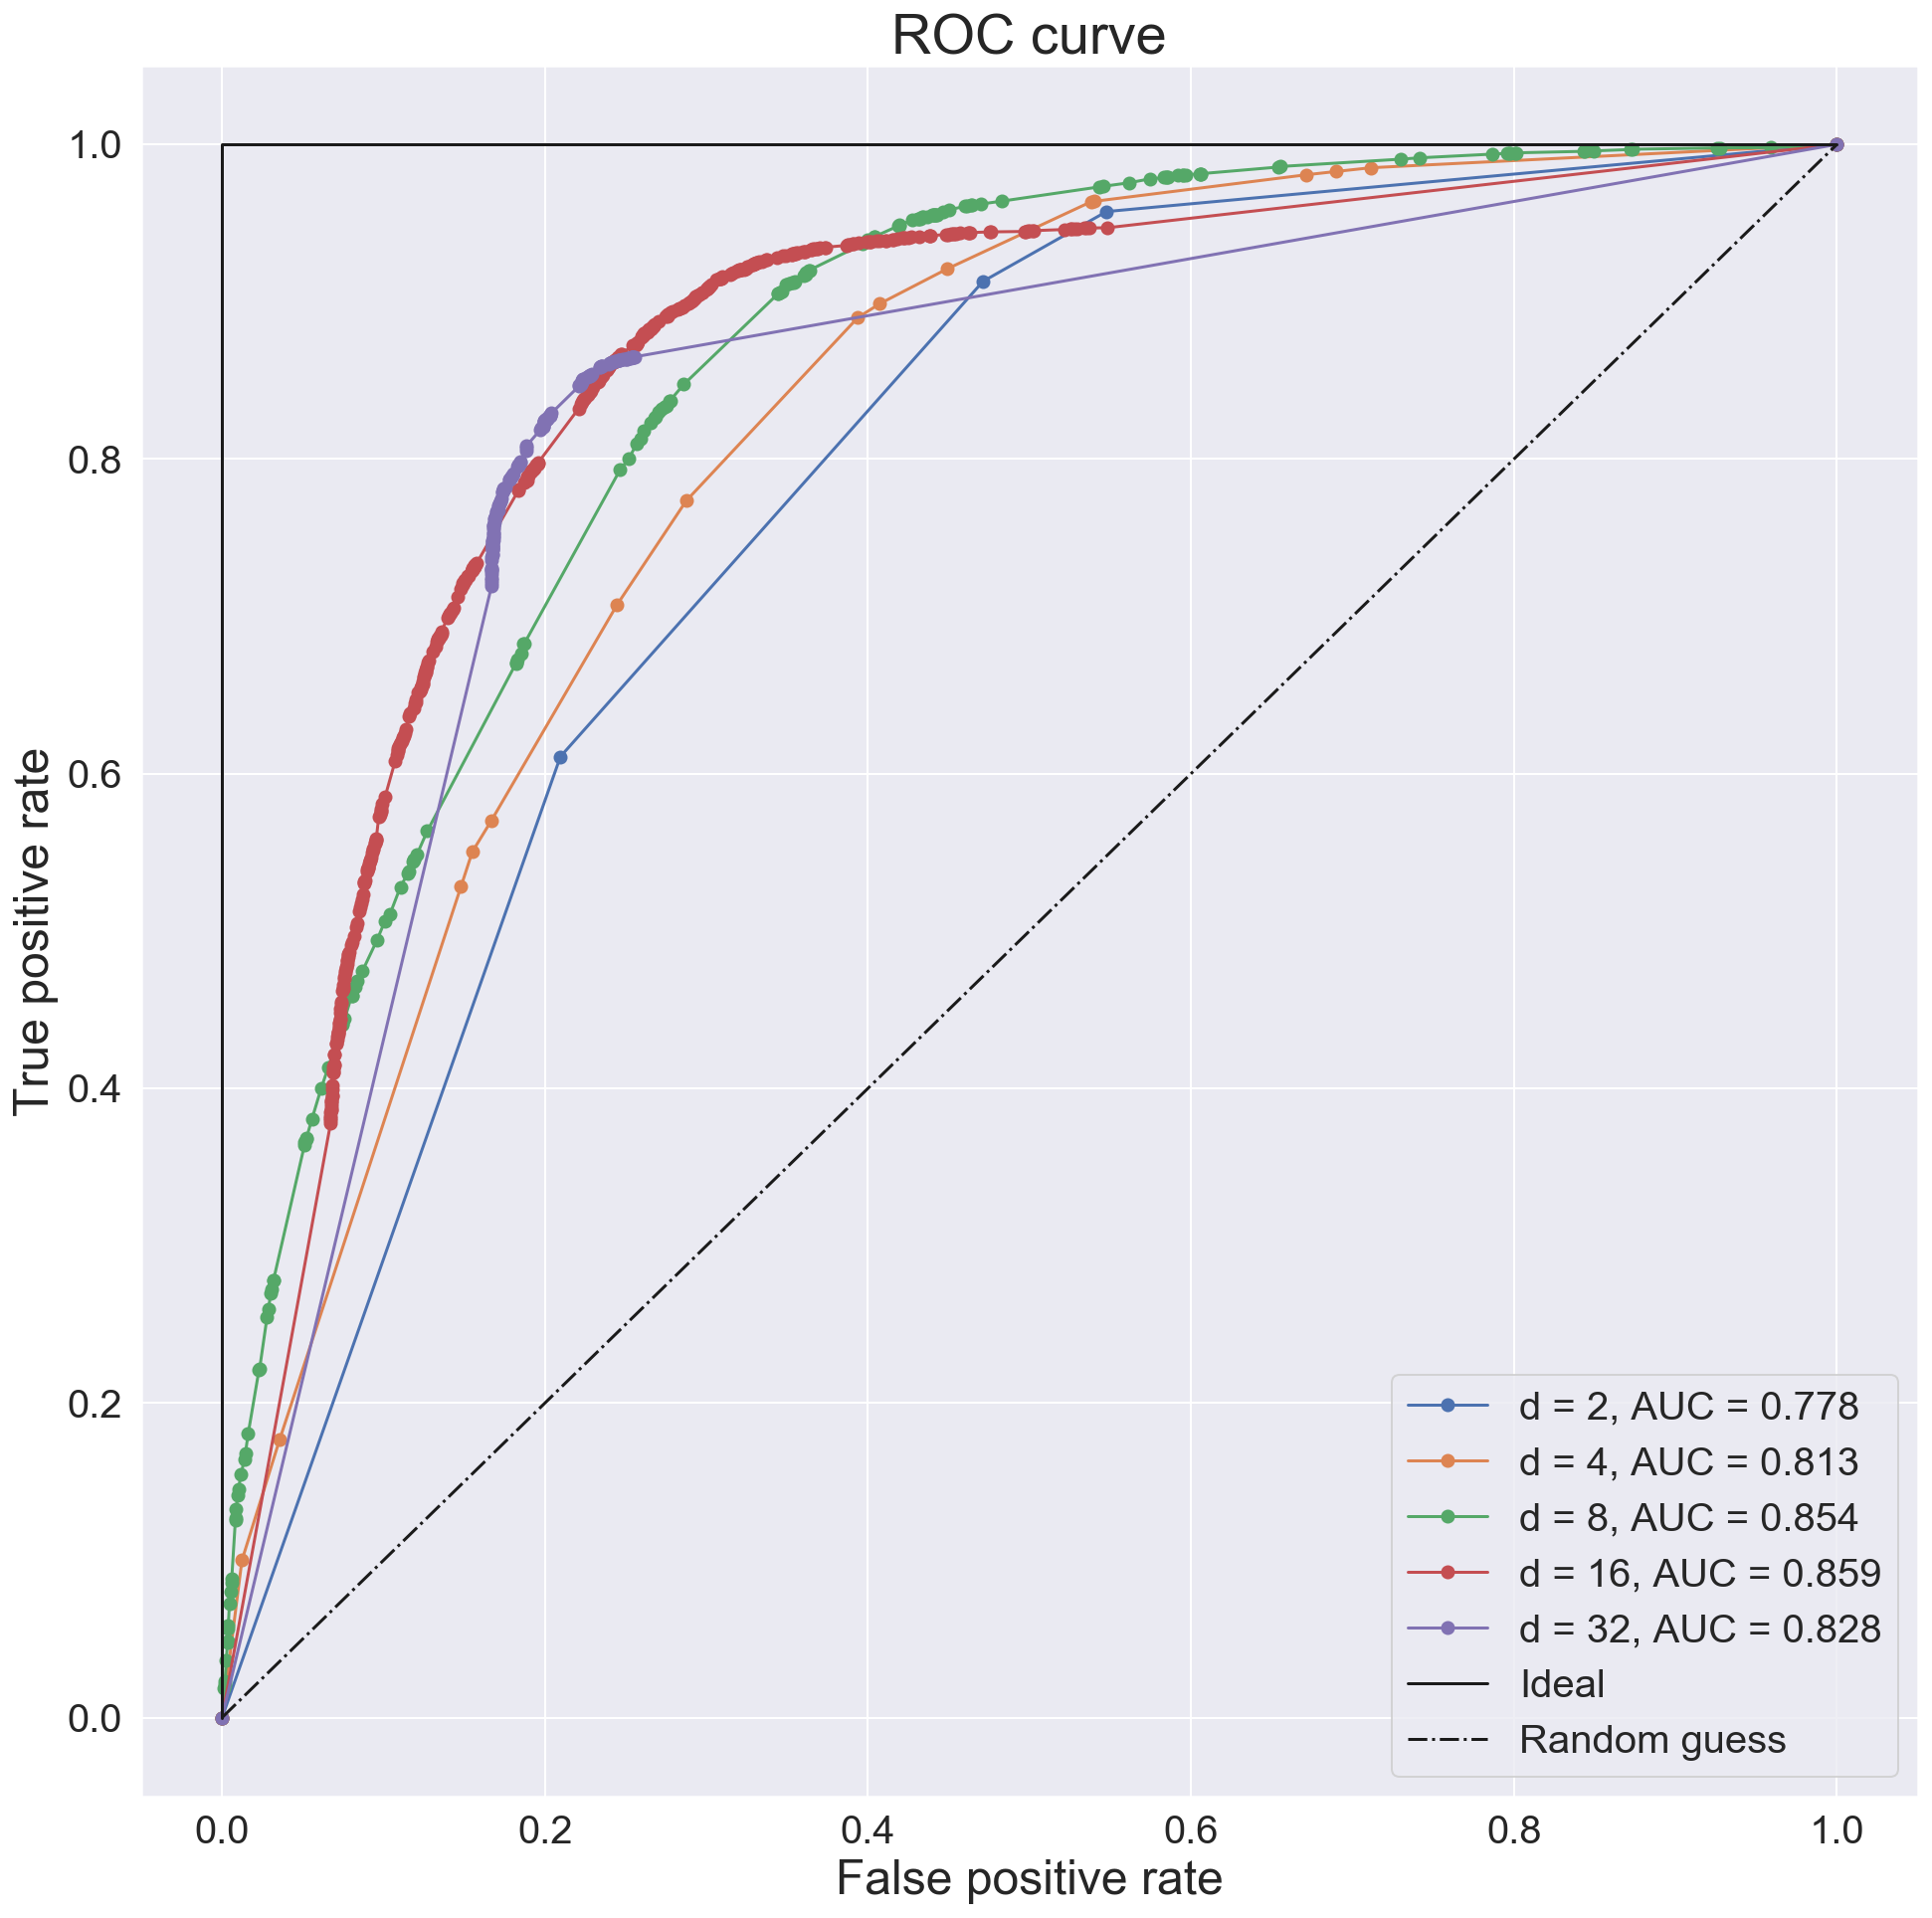

In [20]:
from sklearn.metrics import roc_curve, roc_auc_score

plt.subplots(figsize=(16, 16))
for d in [2, 4, 8, 16, 32]:
    decision_tree = DecisionTreeClassifier(criterion="entropy", random_state=0, max_depth=d)
    decision_tree = decision_tree.fit(x_train, y_train)
    train_accuracy = decision_tree.score(x_train, y_train)
    test_accuracy = decision_tree.score(x_test, y_test)

    y_pred = decision_tree.predict_proba(x_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    a = roc_auc_score(y_test, y_pred)
    plt.plot(fpr, tpr, 'o-', label='d = %d, AUC = %.3f' % (d, a))

plt.plot([0, 0, 1], [0, 1, 1], 'k-', label="Ideal")
plt.plot([0, 1], [0, 1], 'k-.', label="Random guess")
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best');

# Decision Tree Regressor

Instead of just classifying metals and insulators, let us now use the decision tree for regression instead. Here, we will use MSE instead of classification accuracy as the criterion. Also, instead of a simple train/test split, we will use proper 5-fold CV.

In [22]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.metrics import mean_squared_error

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

results = []

for d in range(1, 20):
    decision_tree = DecisionTreeRegressor(criterion="mse", random_state=0, max_depth=d)
    y_pred = cross_val_predict(decision_tree, x, y_reg, cv=kfold)
    mse = mean_squared_error(y_reg, y_pred)
    results.append((d, mse))

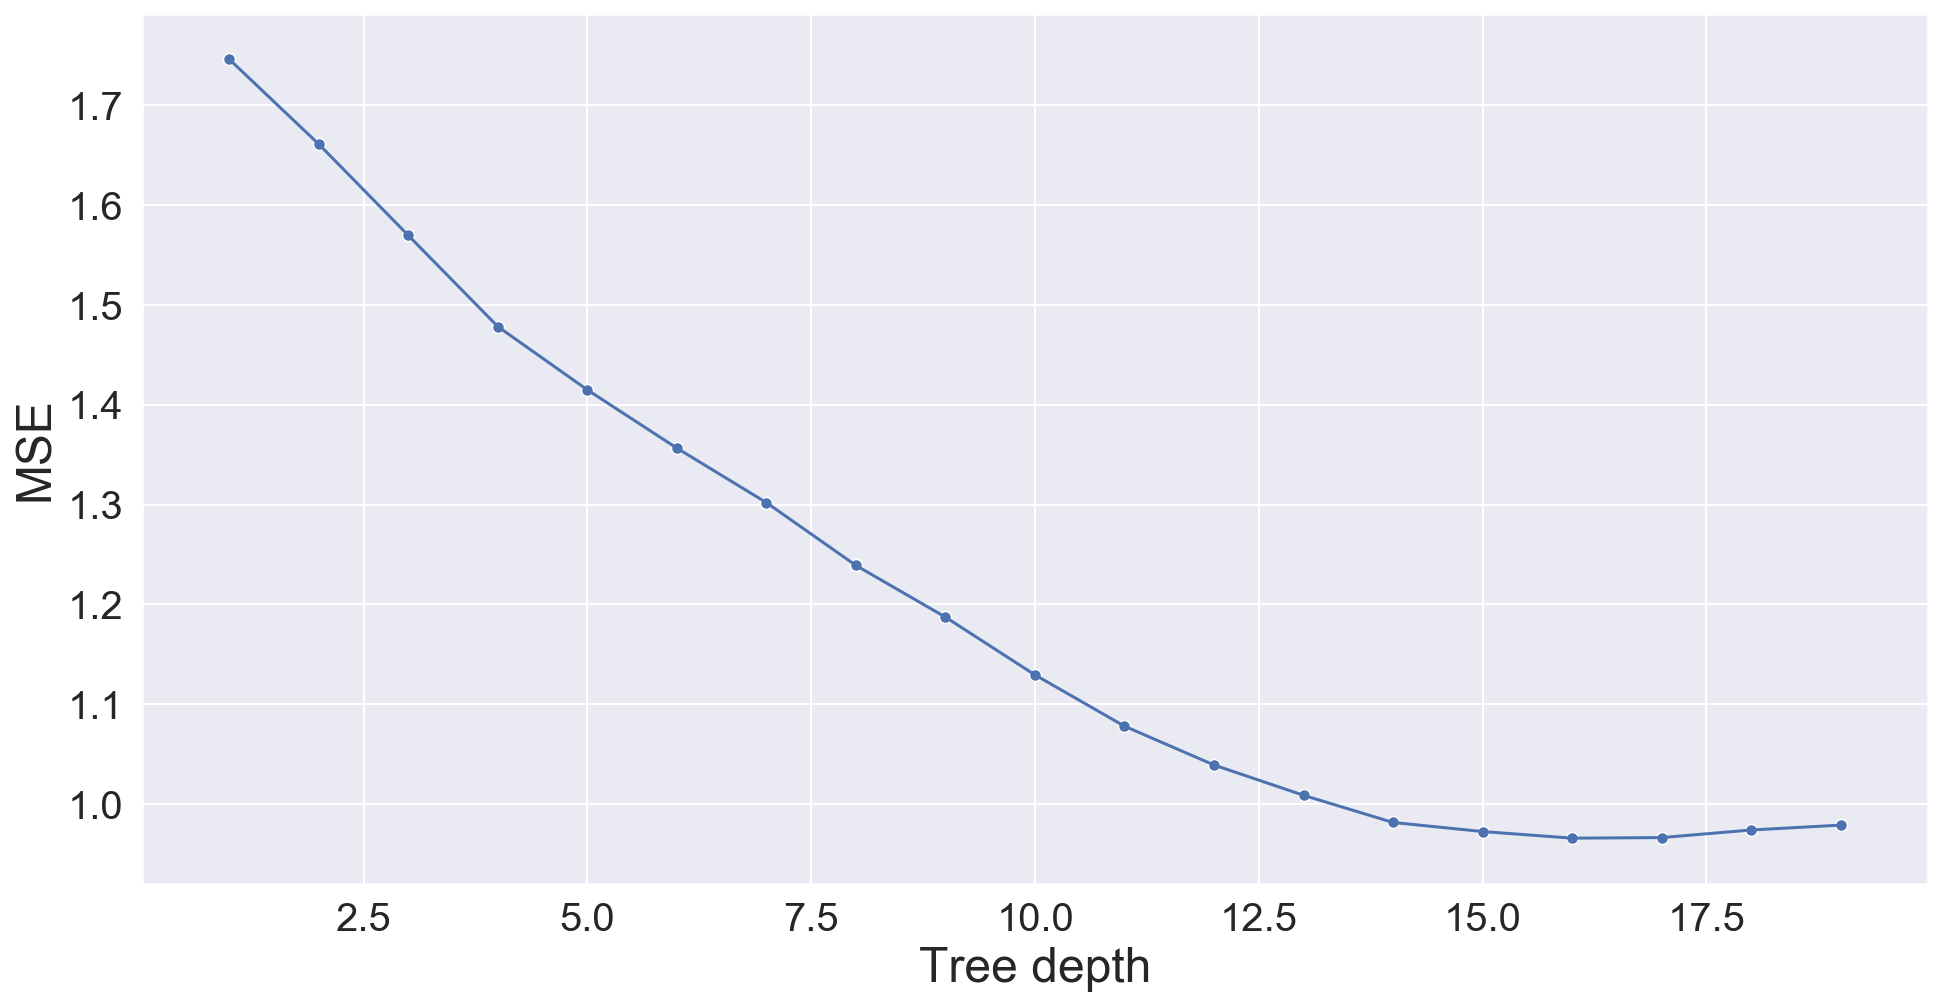

In [23]:
results = pd.DataFrame(results, columns=["Depth", "MSE"])
fig, ax = plt.subplots(figsize=(16, 8))
ax = sns.lineplot(x="Depth", y="MSE", data=results)
ax = sns.scatterplot(x="Depth", y="MSE", data=results, marker='o')
plt.xlabel("Tree depth")
plt.ylabel("MSE");

We observe that an optimal tree depth of around 15 or so in terms of minimizing MSE. We can achieve a MSE of slightly less than 1 eV or so. Not great, but reasonable for such a simple model. Let us now explore how alpha affects the tree depth and the MSE.

In [24]:
x_train, x_test, y_train, y_test = train_test_split(x, y_reg, test_size=0.2)

results = []

for alpha in np.logspace(-4, -1, 10):
    decision_tree = DecisionTreeRegressor(criterion="mse", random_state=0, max_depth=15, ccp_alpha=alpha)
    decision_tree.fit(x_train, y_train)
    y_pred = decision_tree.predict(x_test)
    mse = mean_squared_error(y_test, y_pred)
    results.append((alpha, decision_tree.get_depth(), mse))

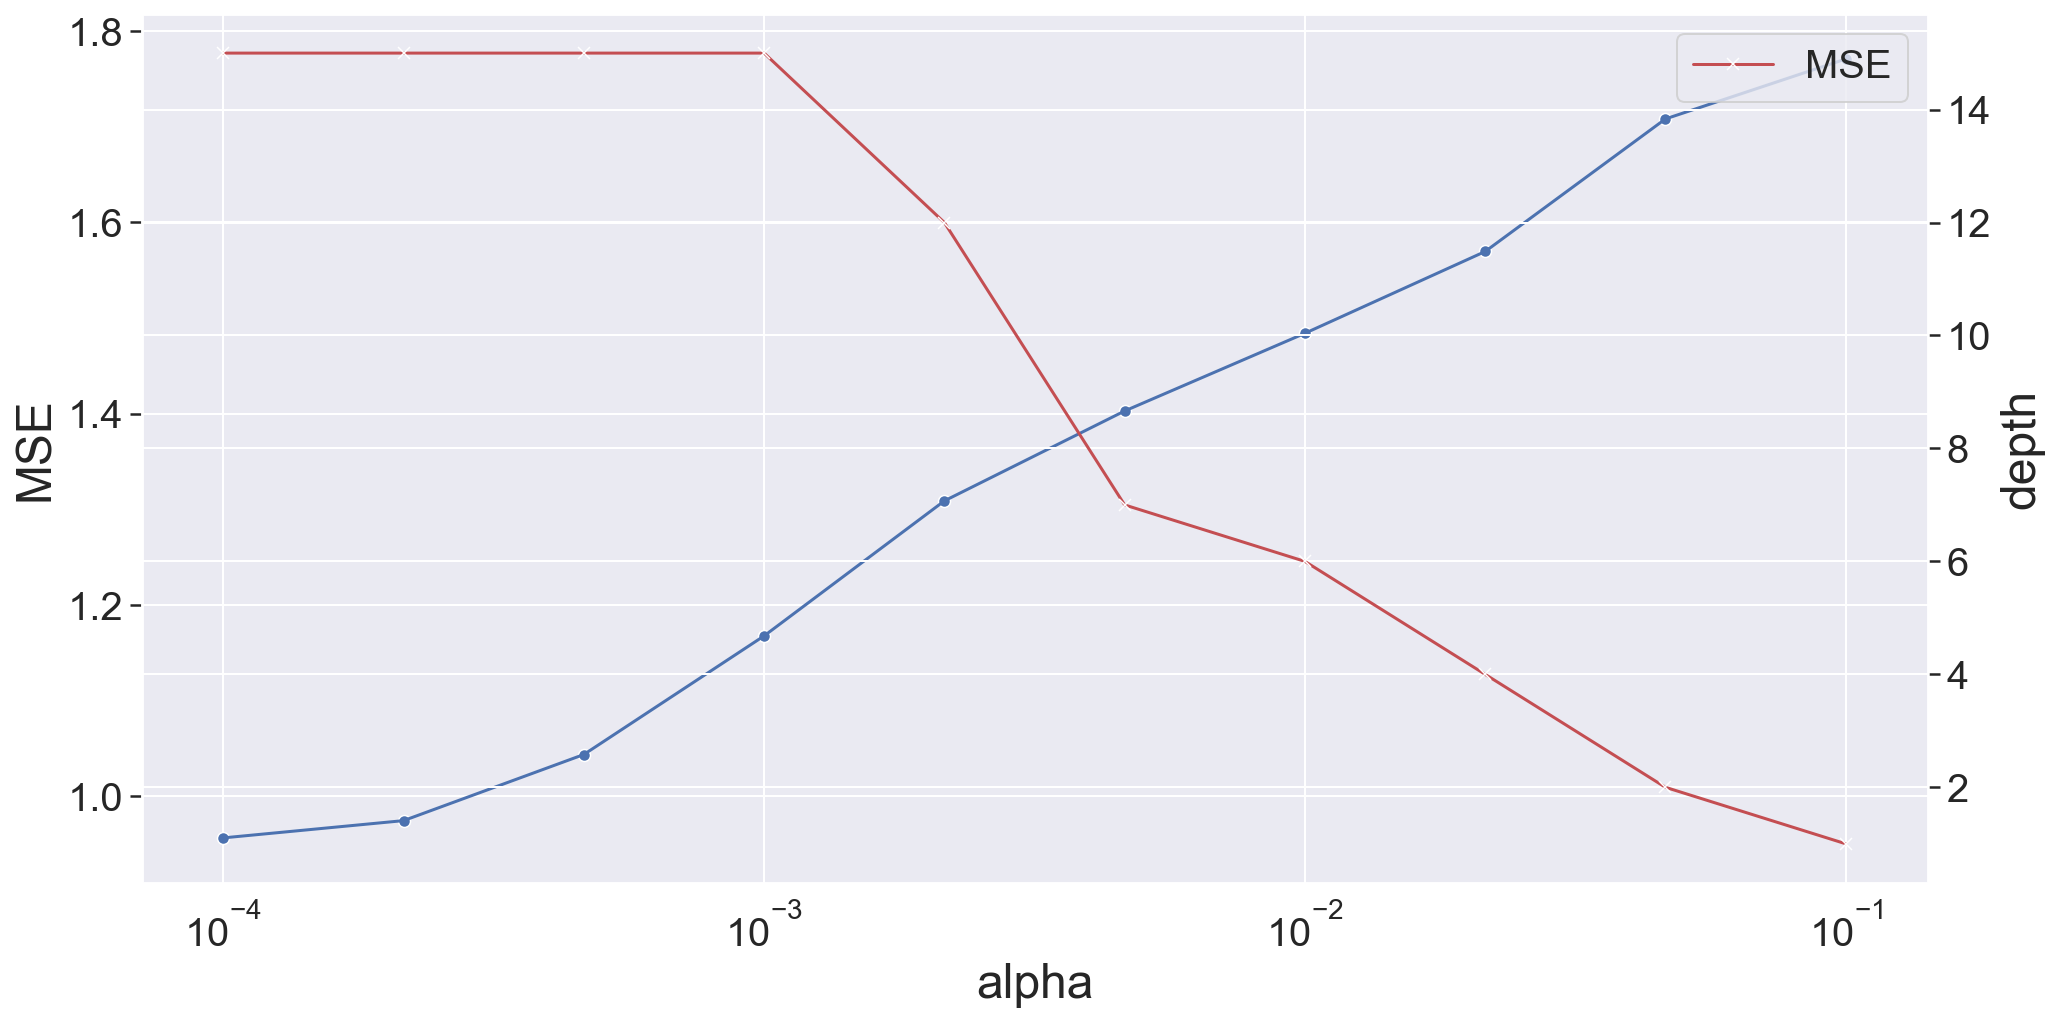

In [25]:
results = pd.DataFrame(results, columns=["alpha", "depth", "MSE"])
fig, ax = plt.subplots(figsize=(16, 8))

ax = sns.lineplot(x="alpha", y="MSE", data=results)
sns.scatterplot(x="alpha", y="MSE", data=results, marker='o')
ax2 = plt.twinx()
sns.lineplot(x="alpha", y="depth", data=results, color="r", marker='x', ax=ax2)
plt.legend(["MSE", "Depth"])
plt.xscale('log')
plt.xlabel(r"$\alpha$");

As we increase $\alpha$, we get a simpler (shallower) tree, but the MSE increases.

Let's look at a relatively small tree.

In [26]:
decision_tree = DecisionTreeRegressor(criterion="mse", random_state=0, max_depth=15, ccp_alpha=0.01)
decision_tree.fit(x_train, y_train)
y_pred = decision_tree.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
r = export_text(decision_tree, feature_names=list(x.columns))
print("MSE = %.3f" % (mse))
print(r)

MSE = 1.484
|--- FirstIonizationEnergyMean <= 9.16
|   |--- ElectronAffinityMean <= 112.14
|   |   |--- value: [0.10]
|   |--- ElectronAffinityMean >  112.14
|   |   |--- ElectronAffinityMean <= 188.50
|   |   |   |--- value: [0.58]
|   |   |--- ElectronAffinityMean >  188.50
|   |   |   |--- value: [1.86]
|--- FirstIonizationEnergyMean >  9.16
|   |--- ColumnMin <= 3.50
|   |   |--- ElectronAffinityMean <= 165.92
|   |   |   |--- SecondIonizationEnergyMean <= 27.01
|   |   |   |   |--- value: [1.05]
|   |   |   |--- SecondIonizationEnergyMean >  27.01
|   |   |   |   |--- AtomicRadiusMin <= 1.27
|   |   |   |   |   |--- value: [2.24]
|   |   |   |   |--- AtomicRadiusMin >  1.27
|   |   |   |   |   |--- ColumnMean <= 12.77
|   |   |   |   |   |   |--- value: [1.36]
|   |   |   |   |   |--- ColumnMean >  12.77
|   |   |   |   |   |   |--- value: [1.93]
|   |   |--- ElectronAffinityMean >  165.92
|   |   |   |--- ColumnMean <= 10.82
|   |   |   |   |--- value: [4.10]
|   |   |   |--- Col

# Adaboost

In [27]:
from sklearn.ensemble import AdaBoostClassifier

results = []
x_train, x_test, y_train, y_test = train_test_split(x, y_class, test_size=0.2)

for n in range(10, 100, 10):
    decision_tree = AdaBoostClassifier(DecisionTreeClassifier(criterion="entropy", random_state=0, max_depth=8), 
                                       n_estimators=n)
    decision_tree = decision_tree.fit(x_train, y_train)
    train_accuracy = decision_tree.score(x_train, y_train)
    test_accuracy = decision_tree.score(x_test, y_test)
    y_pred = decision_tree.predict(x_test)
    results.append((n, 1 - train_accuracy, 1 - test_accuracy))

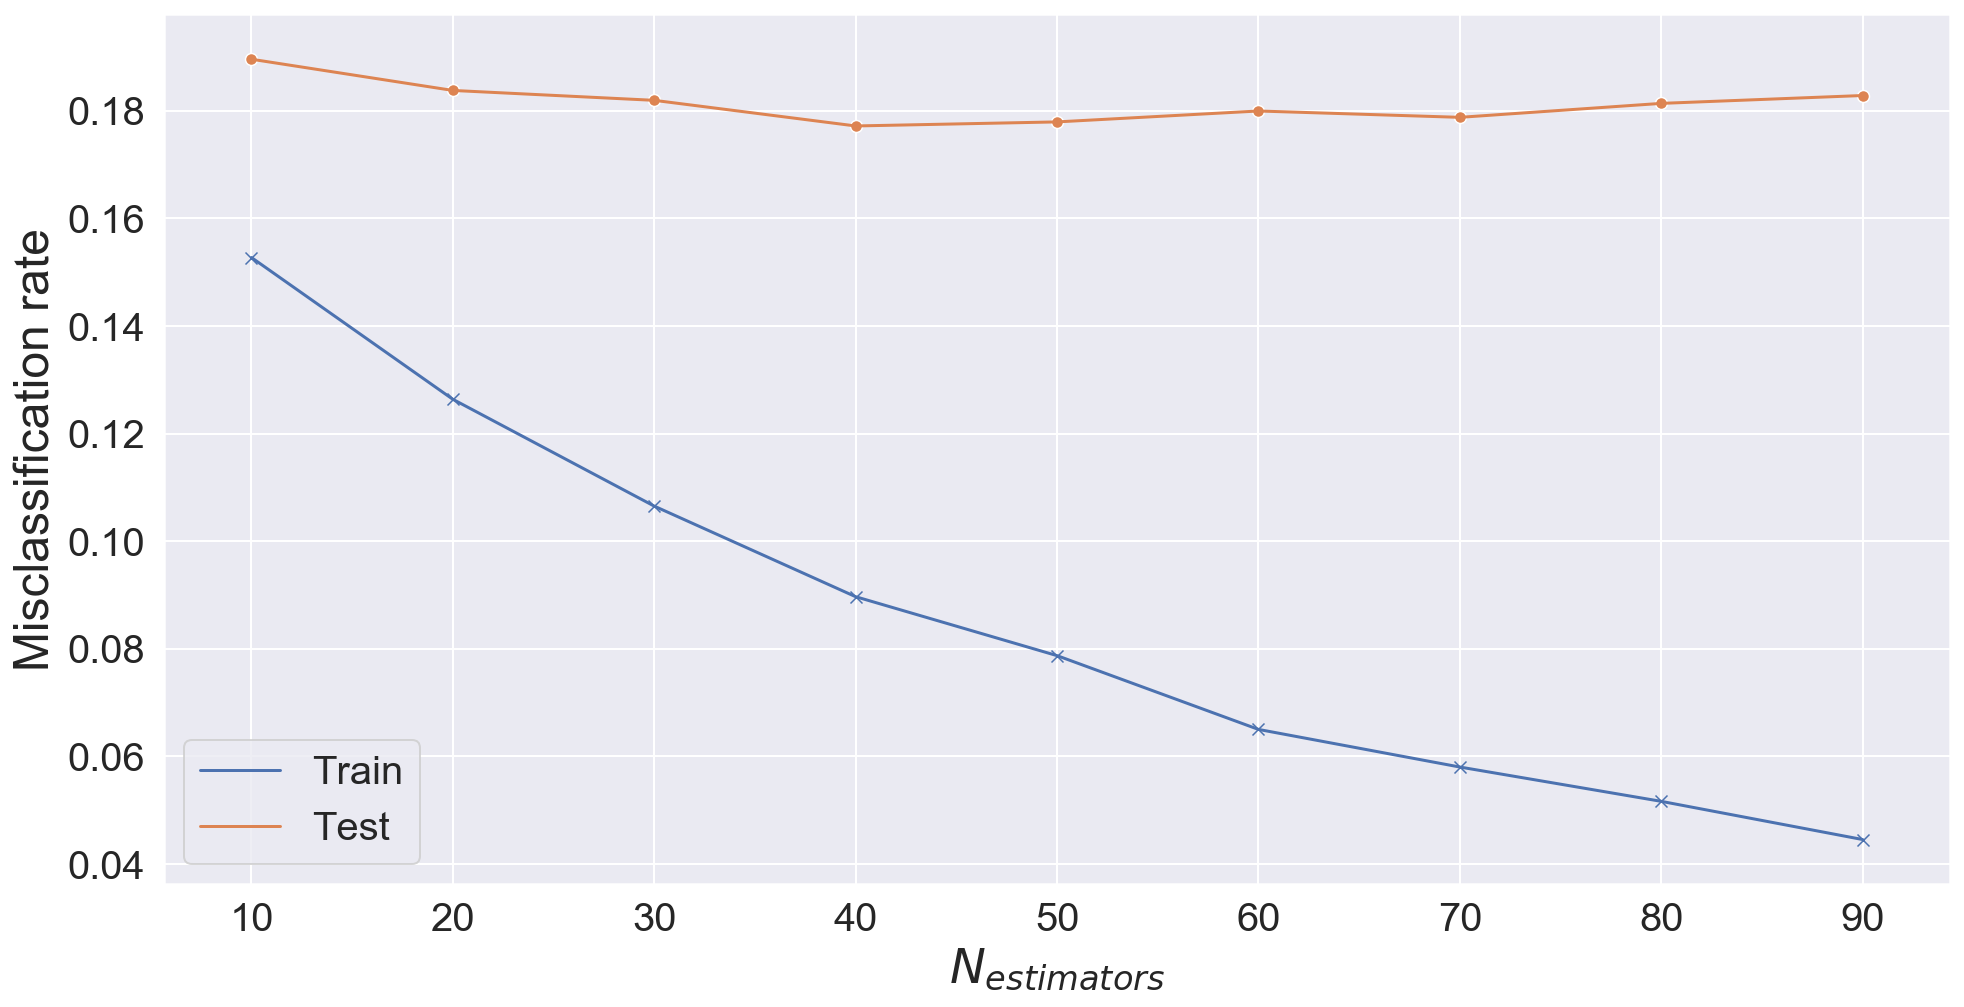

In [28]:
results = pd.DataFrame(results, columns=["n", "Train", "Test"])
fig, ax = plt.subplots(figsize=(16, 8))
ax = sns.lineplot(x="n", y="Train", data=results)
ax = sns.scatterplot(x="n", y="Train", data=results, marker='x')
ax = sns.lineplot(x="n", y="Test", data=results)
ax = sns.scatterplot(x="n", y="Test", data=results, marker='o')
plt.xlabel(r"$N_{estimators}$")
plt.ylabel("Misclassification rate")
ax.legend(["Train", "Test"]);

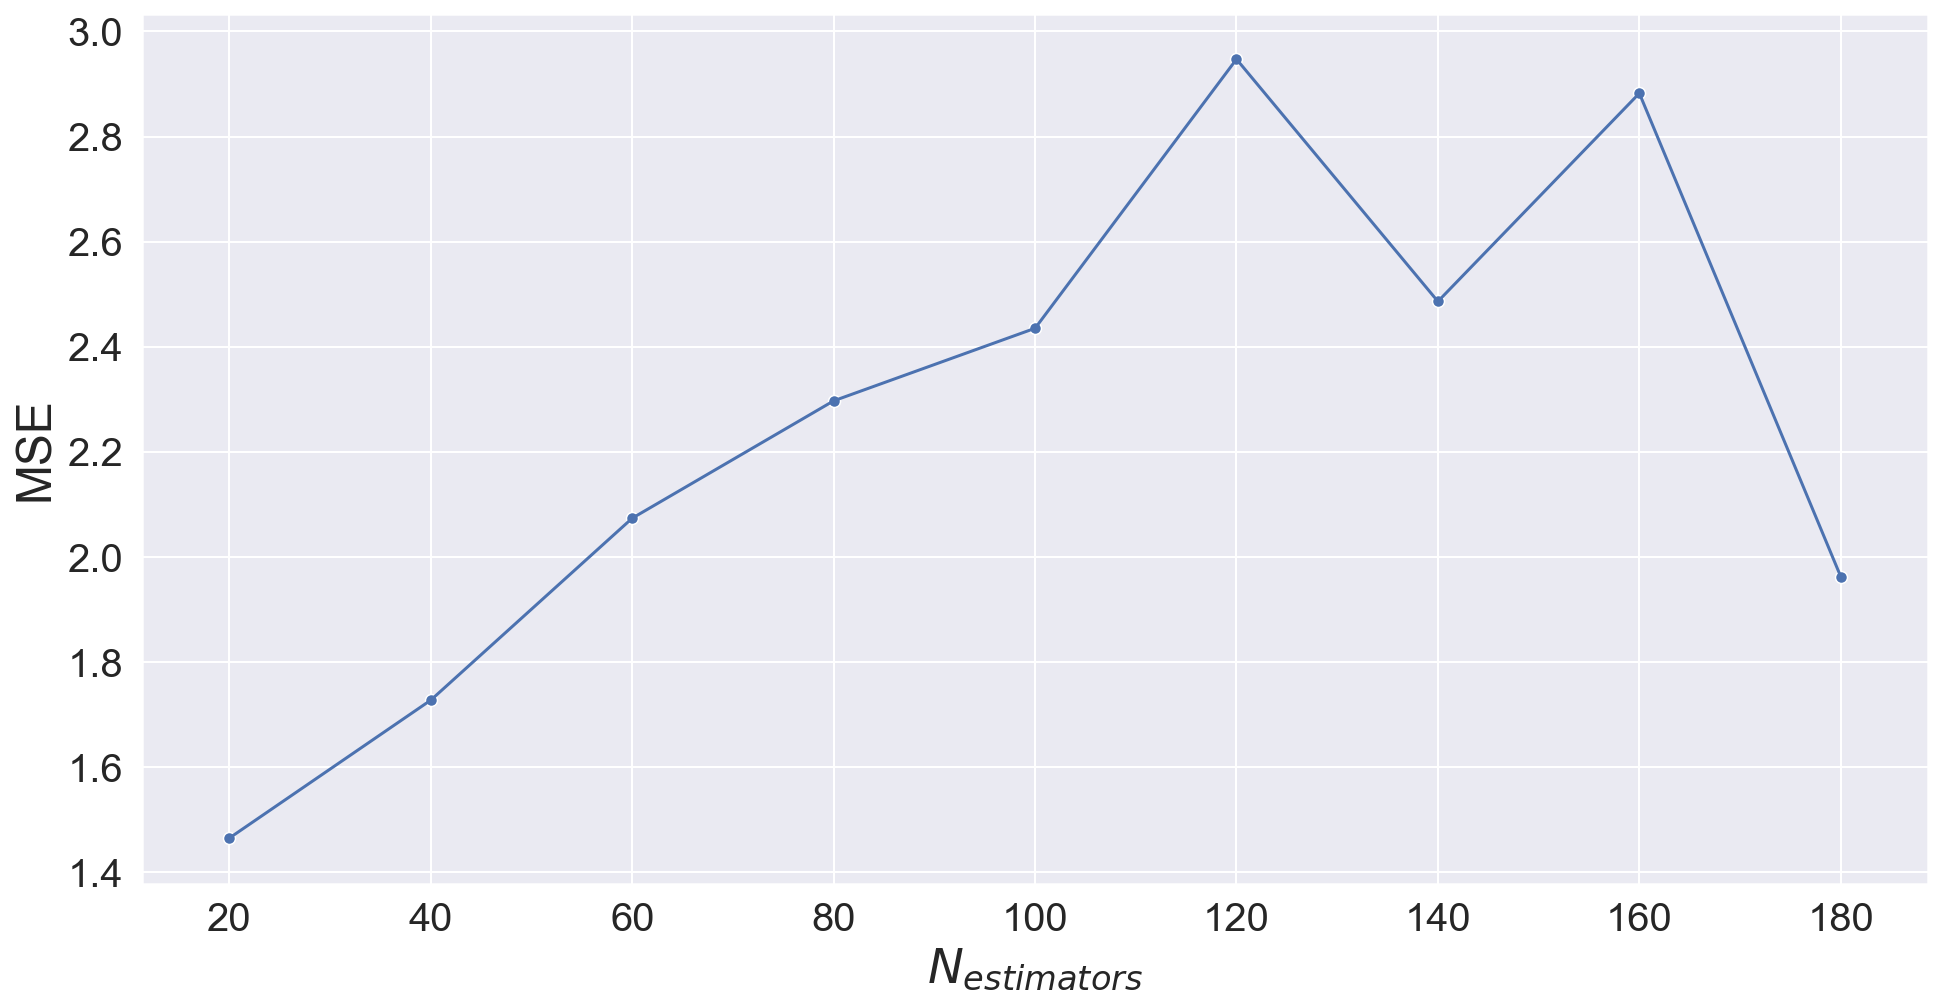

In [29]:
from sklearn.ensemble import AdaBoostRegressor

results = []
x_train, x_test, y_train, y_test = train_test_split(x, y_reg, test_size=0.2)

for n in range(20, 200, 20):
    decision_tree = AdaBoostRegressor(DecisionTreeRegressor(criterion="mse", random_state=0, max_depth=5), 
                                      n_estimators=n)
    decision_tree.fit(x_train, y_train)
    y_pred = decision_tree.predict(x_test)
    mse = mean_squared_error(y_test, y_pred)
    results.append((n, mse))

results = pd.DataFrame(results, columns=["n", "MSE"])
fig, ax = plt.subplots(figsize=(16, 8))

ax = sns.lineplot(x="n", y="MSE", data=results)
sns.scatterplot(x="n", y="MSE", data=results, marker='o')
plt.xlabel(r"$N_{estimators}$");